<img src='figures/implied-pdf.png'>
A peek at the final result; The implied CDF, PMF, and smooth approximation PDF.

# Introduction

Options serve as an insurance product for long term stock investors.  Their pricing of options contract is derived from the uncertainty in the underlying asset's price at the expiration date of a contract.  

At expiration time $T$, the value of a put option contract with strike price $K$ is:

$$
\text{max}(K - S_T, 0)
$$

where $S_T$ is the price of the underlying at time expiration.  $S_T$ is a random variable, and the price the option seller sets for a contract at strike price $K$ reflects their belief on this random variable.  A fair price for the put option can be expressed as:

$$
P(K) = \textbf{E}\left[\text{max}(K- S_T), 0\right] = \int_{-\infty}^ K (K-S_T) f(S_T) dS_T
$$

Where $f(S_T)$ is the probability density function for the stock price at time $T$. A derivative with respect do $K$ and applying Leibinz's integration rule will yield the CDF.

$$
\frac{dP}{dK} = \frac{d}{dK}\int_{-\infty}^K (K-S_T) f(S_T) dS_T = \int_{-\infty}^K f(S_T)dS_T
$$

$$
\frac{dP}{dK} = F_{\text{put}}(K) \\ \

\\
\\
\
\
\frac{d^2P}{dK^2} = p_{\text{put}}(K)
$$

The rate of change in the put option price is equal to the CDF of $S_T$ and the curvature is related to the PDF (PMF in the discrete case).

A similar result can be generalized for call options.

$$

F_{call}(K) = 1 + \frac{dC}{dK} \\ \
\\ \\ \ \
f_{call}(K) = \frac{d^2C}{dK^2}
$$

Using historical options chains on a major index from the Japanese stock exchange, we can compute the implied probability distribution **nonparametrically**, using **isotonic regression** as the monotonic smoothing technique.  

<!-- The advantages of a **nonparamteric** calculation is we make no explicit assumption on the distribution of market returns.   -->

<!-- ## Leibinz integral rule -->

<!-- \frac{d}{dx_i} f\left[g(x_1), g(x_2), ..., g(x_n)\right] = \sum_{i=1}^{n} \left(\frac{d}{dx}g_i(x)\right) \frac{\partial}{\partial x_i} f\left[g(x_1), g(x_2), ..., g(x_n)\right] -->

<!-- ## Multivariate chain rule

$$

\frac{d}{dx_i} f\left[g(x_1), g(x_2), ..., g(x_n)\right] = \sum_{i=1}^{n} \left(\frac{d}{dx}g_i(x)\right) \frac{\partial}{\partial x_i} f\left[g(x_1), g(x_2), ..., g(x_n)\right]

$$

$$
P(K, S_T)
$$ -->

# Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter
from sklearn.isotonic import IsotonicRegression

from time import time


idx = pd.IndexSlice
sns.set_style('whitegrid')
sns.set_palette('tab10')

# if you run this notebook on your personal computer you'll have to download the data
base_file_path = '~/kaggle-data/jpx-stock-exchange-prediction/'

<!-- # Project is a work in progress

## What's been accomplished
* Monotonic and bounded CDFs
* Custom user defined functions
* Interesting looking PMFs
* PDF computation for a signle sample
* Smooothing PDF

## Absolutely necessary to-do list:
* Build isotonic regression from scratch
* Savitkzy golay filter from "scratch"

## To-do list
* try out `kstest` for simulated gammas
* generate interpolated cdfs and compute pdfs (pmfs in near continuous limit)
* construct fictitious Kolmogorov Smirnov tests
* Perform two-sample KS (or Anderson-Darling) tests between calls and puts
* Find a multimodal hypothesis test (ie null is that the hypothesis is unimodal)
* think about fitting a general exponential family of distributions (is this even possible?)
* Last but definitely not least: documentation and annotations -->

## User defined functions (UDF)
Useful for pandas groupby operations

In [28]:
def savgol_pandas(series:pd.Series, window_length, polyorder)->pd.Series:
    '''
    Savitzky-Golay filter for a pandas groupby operation.  
    For polyorder=1 this filter roughly acts like a moving average.

    Args:
    Series: Noise data to smooth
    window_length: Size of the sliding window 
    polyorder:  interpolation polynomial order, usually 1 is just fine.  Higher orders can cause boundary issues.
    '''
    data = savgol_filter(series.values, window_length, polyorder)
    return pd.Series(data = data, index = series.index)

def gradient_pandas(series:pd.Series, index_level = -1)->pd.Series:
    '''
    Custom numpy gradient tool for groupby operations on multi-index pandas dataframes.  
    X data is taken to be in the index of the series, Y data is in series.values.
    Gradient is used to return a centered derivative (i.e. the return is the same length as the input.)
    
    Args:
    series: series.values should have the y data, series.index should have the X data in one of the index levels.
    index_level: the tier of the index that continas the X data
    '''

    price = series.values
    index = series.index.get_level_values(index_level)
    data = np.gradient(price)/np.gradient(index)
    return pd.Series(data=data, index = series.index)


def bullSpread_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical first derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(-1)-obj.shift(1)


def butterflySpread_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical second derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - 2*y{i} + y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(1)+obj.shift(-1) -2*obj.shift(0)

# Part I data cleaning and computing the CDF

## Exploratory data analysis

### Importing

In [29]:
options_import = pd.read_csv('train_files/options.csv')
# options_import.to_json()
# import pickle
# with open('options_data', 'wb') as f:
#     pickle.dump(options_import.to_json(), f)

/tmp/ipykernel_20577/3743955313.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv('train_files/options.csv')


In [30]:
options_import['Date'] = pd.to_datetime(options_import['Date'])

options_import['Expiry'] =options_import.LastTradingDay.astype(str)
options_import['Expiry'] = pd.to_datetime(options_import['Expiry'], format = '%Y%m%d')

drop_cols = ['NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose',]

# set the approriate indices, and drop the unused columns
options = options_import.drop(drop_cols, axis = 1)
minimum_volume = 1
options = options[options.WholeDayVolume>=minimum_volume]
# Remove training examples that had not trading volume
# minimum_volume = 10


<font size=4>
* Zero volume days have been removed, but there's still many 

## The underlying
The contracts in these datasets are for the Nikkei 225 index, and there are a variety of Nikkei 225 ETFs provided in the kaggle dataset.  I'll consider which one to use as the underlying, they should be in good approximation to the actual index

/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Date', ylabel='Close'>

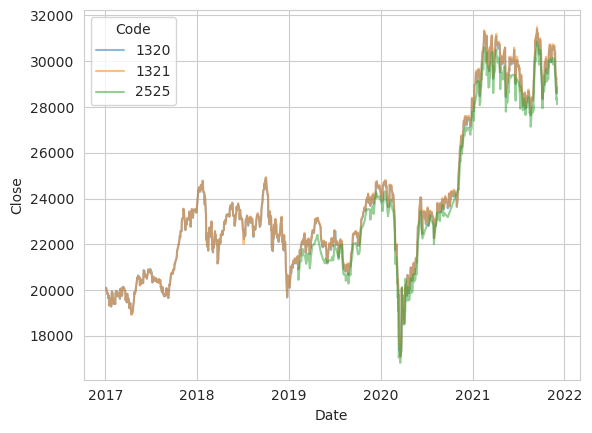

In [31]:
# a compilation of details about each security in the datasaet
# sec_stats = pd.read_csv(base_file_path+'stock_list.csv').rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

secondary_prices = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices.Date = pd.to_datetime(secondary_prices.Date)
secondary_prices = secondary_prices.set_index(['Code', 'Date']).sort_index()
nikkei_etfs = secondary_prices.loc[[1320, 1321, 2525]]

# remove the high memory 
del secondary_prices

fig, ax = plt.subplots()
sns.lineplot(nikkei_etfs, x = 'Date', y = 'Close', hue = 'Code', palette= 'tab10', alpha = 0.5)

* The green security seems to be the odd one out.  
* By inspection security code 1320, Daiwa ETF-Nikkei 225 will be chosen as the underlying

In [32]:
# Merge the underlying stock data to the options dataframe
etf_code = 1320
nikkei_etfs['UnderlyingClose'] = nikkei_etfs.Close
options = options.reset_index().merge(nikkei_etfs.loc[etf_code, 'UnderlyingClose'], how = 'left', on = 'Date')
options = options.set_index(['Date', 'Expiry', 'Putcall', 'StrikePrice']).sort_index()


In [33]:
# cutoff for strike price
underlying_cutoff =15/100
# Some useful indices for groupby operations
indices = ['Date','Expiry', 'Putcall']

# Boolean indexer for contracts with strikes that are farther than 10% from the underlying.
complete_set =options.copy()
far_strikes_cond = complete_set.groupby(indices, group_keys=False).apply(
    lambda x: np.abs((x.index.get_level_values('StrikePrice')/x.UnderlyingClose-1))>underlying_cutoff)

# I want to keep the pricing data very far from the strikes for curiosity reasons.

options = complete_set[~far_strikes_cond].copy()

### Option chain list
a compendium of the daily trading activity for all the chains for a given expiry in the dataset

In [34]:
# Useful groupby indices

# A list of all the contracts in my dataset
chain_list = pd.DataFrame()

#aggregated trading volume (over all possible strikes) at a specific contract
chain_list['TotalVolume'] = options.groupby(indices)[['WholeDayVolume']].sum()

#Number of strike prices in a contract
chain_list['N_strikes']=options.reset_index('StrikePrice').groupby(indices)['StrikePrice'].nunique()


N_strikes = options.index.get_level_values('StrikePrice').unique().__len__()

# Filter contracts such that the whole day trading volume is greater than the number of strikes
chain_list = chain_list[chain_list.TotalVolume>1*N_strikes]

#rank the contracts by their volumes
chain_list['VolumeRank'] = chain_list['TotalVolume'].rank(ascending=False)
chain_list.sort_values(by = 'VolumeRank', inplace = True)

# use a hard cutoff instead of quantile in case the code is ran twice
chain_volume_cutoff_byQuantile = chain_list.TotalVolume.quantile(0.25)
chain_volume_cutoff = 1000
print('minimum_volume for any chain', chain_volume_cutoff_byQuantile)
liquid_chains = chain_list[chain_list['TotalVolume']>chain_volume_cutoff].sort_index().index
liquid_chains

options=options[options.index.droplevel(-1).isin(liquid_chains)]

minimum_volume for any chain 697.0


### Visualizing data

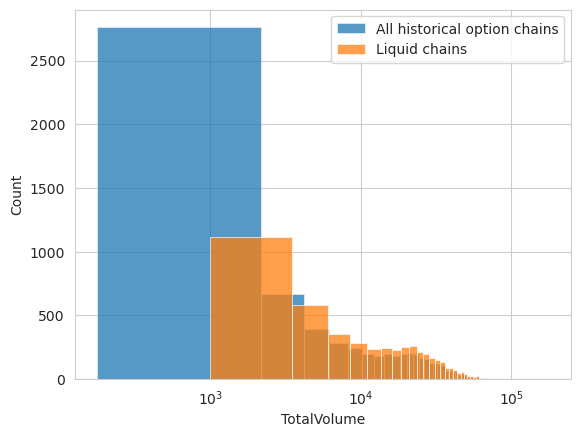

In [35]:
fig, ax = plt.subplots()

sns.histplot(chain_list, x='TotalVolume', label='All historical option chains')
sns.histplot(chain_list.loc[liquid_chains], x='TotalVolume', label='Liquid chains')
ax.set_xscale('log')

ax.legend()

<font size = 5>

* Option chains that had a volume of at least 700 are considered liquid and kept in the dataset

In [36]:
# # Call and put close prices on a particular day for a particular expiry
# fig, ax = plt.subplots()
# # day = '2017-01-04'
# day = '2021-12-03'
# expiry = '2021-12-09'
# df=options.loc[idx[day, expiry]]

# j=sns.scatterplot(df, x='StrikePrice', y = 'WholeDayVolume', hue='Putcall', palette='tab10')

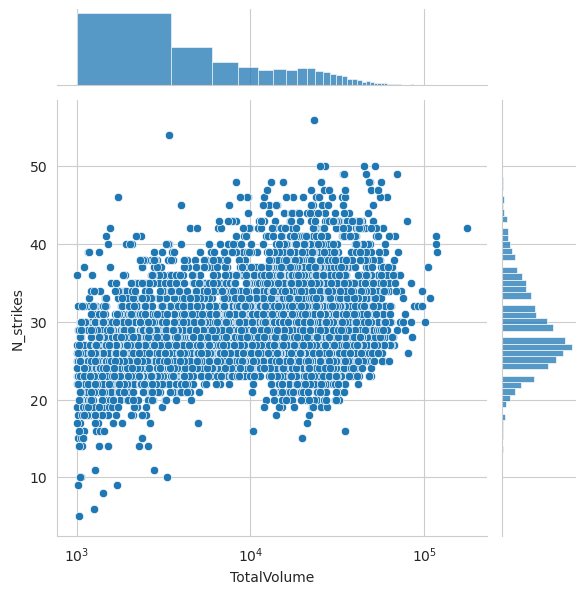

In [37]:
# fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))

# sns.histplot(chain_list.N_strikes, ax=ax[0])
# g=sns.jointplot(chain_list,y='N_strikes', x='TotalVolume')
g=sns.jointplot(chain_list.loc[liquid_chains],y='N_strikes', x='TotalVolume')
g.ax_joint.set_xscale('log')

<font size = 5>

* N_strikes is the number of strikes on a specific chain.
* Seems like 20 strikes is a good minimum number of strike prices to offer for a given expiry. 
<!-- * A jointplot of N_strikes v.s. TotalVolume suggests I should only consider securities that traded with at least 15 different strike prices. That would remove most of the low trading securities. -->

In [38]:
# # Identify the contracts that have at least 20 strikes traded on a particular day
# min_strikes = 20
# good_training_examples=chain_list[chain_list.N_strikes>=min_strikes].sort_index().index

# # Exclude the training examples that are not considered "good"
# options = options[options.index.droplevel(-1).isin(good_training_examples)].copy()



### Isotonic smoothers/regressors

In [39]:
def isotonicSmoother_pandas(
        df:pd.DataFrame, y_col:str, 
        direction_encoder_col=None, direction:bool=None, 
        index_level = -1,
        ymin = None, ymax = None):
    '''
    
    '''
    if direction_encoder_col==None:
        if direction ==None: dir = True
        else: dir = direction
    else:
        dir = df[direction_encoder_col].all()  # need to put a safety check here
    
    s = df[y_col].dropna()
    iso_regressor = IsotonicRegression(increasing = dir, y_min = ymin, y_max = ymax)
    y_hat = iso_regressor.fit_transform(X=s.index.get_level_values(index_level), y = s)
    return pd.Series(y_hat, s.index)

def weightedIsotonicSmoother_pandas(
        df:pd.DataFrame, 
        y_col:str, 
        weight_col:str,
        direction_encoder_col=None, direction:bool=None, 
        index_level = -1,
        ymin = None, ymax = None,
        ):
    '''
    
    '''
    if direction_encoder_col==None:
        if direction ==None: dir = True
        else: dir = direction
    else:
        dir = df[direction_encoder_col].all()  # need to put a safety check here
    
    data = df[[y_col, weight_col]].dropna()
    X, y, weights = data.index.get_level_values(index_level), data[y_col], data[weight_col]
    
    iso_regressor = IsotonicRegression(increasing = dir, y_min =ymin, y_max=ymax)
    iso_regressor.fit(X, y, sample_weight = weights)
    y_hat = iso_regressor.predict(X)
    return pd.Series(y_hat, index=data.index)

<!-- # Computing the implied probability distribution:
Brief outline:

1. Calculate implied CDF.
2. Try and perform a kolmogorov smirnov test on a well behaved example.
    * Seems like a decent well behaved example is (Timestamp('2021-09-06 00:00:00'), Timestamp('2021-09-09 00:00:00')).

Denoising procedure:
1. Denoise the call and put premium data with a volume weighted isotonic regressor. 
2. Calculate the bull spread, and then compute the implied CDF.
3. Denoise the implied CDF with another volume weighted isotonic regressor -->


In [40]:

# A series that encodes whether the premiums are expected to increase or decrease with strike price
# 1 for puts; put contracts have increasing premiums with increasing strikes
options['Putcall_encoder']=options.index.get_level_values('Putcall') ==1 

t0 = time()
options['Close_iso'] = options.groupby(indices, group_keys=False).apply(
    isotonicSmoother_pandas, 'WholeDayClose', 'Putcall_encoder' )
print('Close_iso runtime', time()-t0, 's')

t0 = time()
options['Close_sm']=options.groupby(indices, group_keys=False).Close_iso.apply(savgol_pandas, 3, 1)
print('Close_sm runtime', time()-t0, 's')

### Calculate the bull spreads (premium at strike K+1 - premium at strike K-1) ###
options['bull'] = bullSpread_pdgroupby(options['Close_iso'].groupby(indices))

options['K'] = options.index.get_level_values('StrikePrice')
options['dK']=bullSpread_pdgroupby(options['K'].groupby(indices, group_keys=False))

options['slope'] = options['bull']/(options['dK'])
options['cdf']= options['slope'] + (options['Putcall_encoder']==False)

# Denoise the CDF with isotonic regression
t0 = time()
options['cdf_iso'] = options.groupby(indices, group_keys=False).apply(
        isotonicSmoother_pandas, y_col='cdf', direction=True, ymin=0, ymax=1); 
print('cdf_iso runtime', time()-t0,  's')



### VOLUME WEIGHTED CALCULATIONS ###

# Compute the weights for isotonic regressor
options['logVolume'] = np.log1p(options['WholeDayVolume'])
weights_column = 'WholeDayVolume'

# Denoise the closing premiums with a weighted isotonic regressor
t0 = time()
options['Close_iso_weighted'] = options.groupby(indices, group_keys=False).apply(
    weightedIsotonicSmoother_pandas, 
    y_col='WholeDayClose', 
    weight_col = weights_column,
    direction_encoder_col ='Putcall_encoder',
    ); 
print('Close_iso_weighted runtime', time()-t0, 's')

# Denoise the CDF with log(1+Volume) weighted isotonic regression
t0 = time()
options['cdf_iso_weighted'] = options.groupby(indices, group_keys=False).apply(
        weightedIsotonicSmoother_pandas, y_col='cdf', 
        weight_col=weights_column, direction=True, ymin=0, ymax=1)
print('cdf_iso_weighted runtime', time()-t0, 's')


# plotting arguments for seaborn
plot_args =  {'hue': 'Putcall', 'palette':'tab10'}





Close_iso runtime 3.7329483032226562 s
Close_sm runtime 1.270082712173462 s
cdf_iso runtime 3.6045403480529785 s
Close_iso_weighted runtime 5.569315195083618 s
cdf_iso_weighted runtime 6.3924241065979 s


##  CDF example

(Timestamp('2017-11-09 00:00:00'), Timestamp('2017-11-09 00:00:00'))
Interest rate is:  0.35999999999999993 Spread in the rate is: 2.1852793414608445e-18


/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-pac

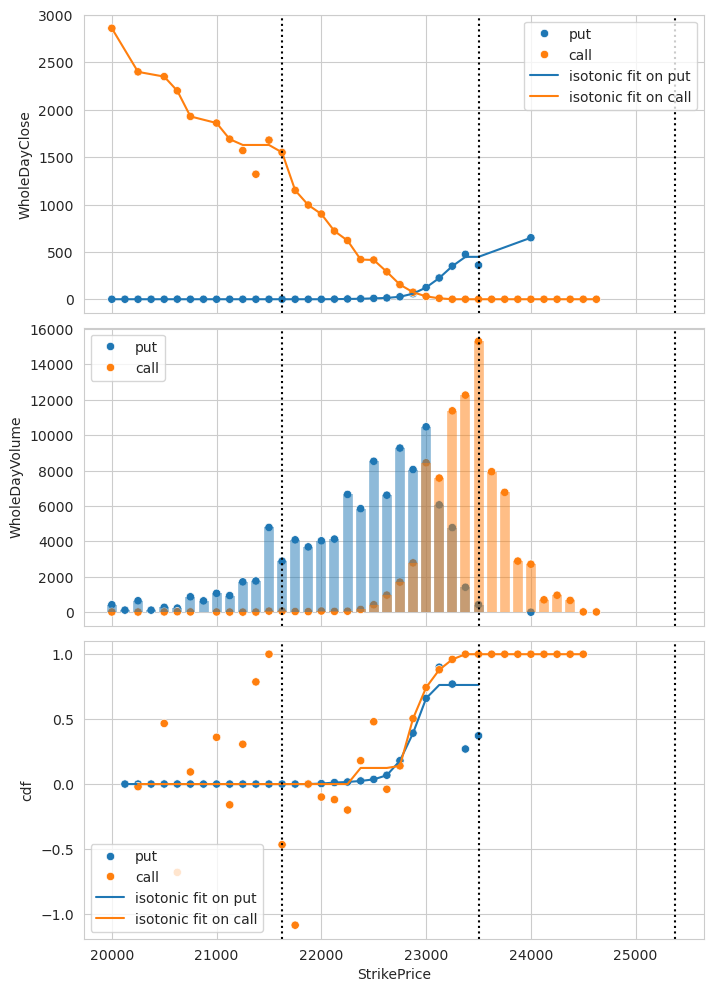

In [58]:
# 13 has a good example of going below the limits
# example 300 seems well behaved
example_number = 6
example = chain_list.index[example_number]
print(example[:-1])
df = options.loc[example[:-1]]
print('Interest rate is: ', 100*df.InterestRate.mean(), 'Spread in the rate is:', df.InterestRate.std())


fig, ax = plt.subplots(3, 1, figsize = (8, 2*6), sharex=True)
fig.subplots_adjust(hspace = 0.05)

# AXES 0
sns.scatterplot(df, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0], **plot_args)
sns.lineplot(df, x = 'StrikePrice', y = 'Close_iso_weighted', ax=ax[0], **plot_args)

handles, labels = ax[0].get_legend_handles_labels()
labels = ['put', 'call',  'isotonic fit on put', 'isotonic fit on call']
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())

# AXES 1
sns.scatterplot(df, x = 'StrikePrice', y='WholeDayVolume', ax = ax[1], alpha = 1, **plot_args)
for i, row in df.iterrows():
    if row['Putcall_encoder'] ==True:color = 'tab:blue'
    else: color = 'tab:orange'
    ax[1].vlines(row['K'], 0, row['WholeDayVolume'], alpha =0.5, linewidth = 7, color = color)

handles, labels = ax[1].get_legend_handles_labels()
labels = ['put', 'call']
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys())

# AXES 2
sns.scatterplot(df, x = 'StrikePrice', y = 'cdf', ax=ax[2], **plot_args)
sns.lineplot(df, x = 'StrikePrice', y = 'cdf_iso_weighted', ax=ax[2], linestyle='-', **plot_args)

handles, labels = ax[2].get_legend_handles_labels()
labels = ['put', 'call',  'isotonic fit on put', 'isotonic fit on call']
by_label = dict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys())

# Annotations 
for a in ax:
    for percentile in [0.92, 1, 1.08]:
        a.axvline(df['UnderlyingClose'].iloc[0]*percentile, color = 'k', linestyle = ':')

<font size =5>

* A volume weighted isotonic regressor is fitted to the closing price versus the strike price. 
* The regressor is constrained to be bounded between 0 and 1.  

# Part II Non-parametric computation of the implied PDF
* Now that we have clean data, we can look towards computing a PDF.  
* A CDF gives us all the probabilistic interpretation we'd need, but a PDF is a nice visual tool and can help think about:
    * Modes of the distribution
    * Tail behaviors
    * Skewness
    
all of which can be interesting features in a alpha or beta forecasting model.

In [18]:
def weightedSum_pandas(df:pd.DataFrame, y_col:str, weight_col:str, stack_level:str, index_level=-1, dropna=True):
    '''
    Returns a pandas series that is a weighed average of two similiar series, 
    that have a duplicated bottom tier index.  
    An example of such would be the prices of options on a given day for a given expiry.  
    Such an example would have pricings data for call options, and pricing data for put options,
    at potentially overlapping strikes.  

    Args:
    '''
    if dropna==True: data = df[[y_col, weight_col]].dropna()
    weighted_y = (data[weight_col]*data[y_col]).unstack(stack_level).sort_index().sum(axis=1)
    weights = data[weight_col].unstack(stack_level).sort_index().sum(axis = 1)
    return pd.Series(data = weighted_y/weights, index = weighted_y.index)
    # df = data[[y_col, weight_col]].unstack(stack_level)

def splineInterp_pandas(series:pd.Series,  N=None, index_level=-1, col_name = 0, dydx:bool = True, integral:bool = False):
    '''
    Returns a pandas dataframe with an index of length N,
    using pieceiwise cubic hermitie interpolating polynomials (Pchip).
    Monotonicty is desired here because the CDF is montonic. 

    Args:

    '''

    s = series.dropna()
    x, y = s.index.get_level_values(index_level), s.values
    if N == None: x_samp = x
    else: x_samp = np.linspace(x.min(), x.max(), N)
    interp = PchipInterpolator(x,y)
    y_interp = interp(x_samp)

    index_names = s.index.names; 
    interp_frame = pd.DataFrame(
        data = np.array([x_samp, y_interp]).T, 
        columns=[index_names[index_level], col_name]
    )

    # It's weird but you have to get the original index by converting it to the list and taking the 0th element
    original_index = list(s.index.droplevel(level=index_level).drop_duplicates())[0]
    
    for i, idx in enumerate(original_index): 
        interp_frame[index_names[i]] = idx
    interp_frame.set_index(s.index.names, inplace=True)

    if dydx: interp_frame['dydx'] = interp.derivative()(x_samp)
    if integral: interp_frame['integral'] = interp.integrate()(x_samp)
    return interp_frame

def centeredFirstDerivative_pandas():
    return

def centeredSecondDerivative_pandas():
    return


In [19]:
# implied.cdf.groupby(indices[:-1], group_keys=True).apply(splineInterp_pandas, N=10)

## Blending implied CDFs

* If I take a volume weighted average of the CDFs from put option pricing and call option pricing, I should be able to get a relatively smooth montonic curve.  
* I'd imagine

In [20]:
implied = pd.DataFrame()
implied['cdf'] = options.groupby(indices[:-1], group_keys=False).apply(
    weightedSum_pandas, 
    y_col='cdf_iso_weighted', weight_col='WholeDayVolume', 
    stack_level='Putcall'
)
# implied = implied.sort_index()
implied['pmf']=implied.groupby(indices[:-1], group_keys=False).cdf.diff()
implied['K'] = implied.index.get_level_values('StrikePrice')

interp_implied = implied.groupby(indices[:-1], group_keys=False).cdf.apply(splineInterp_pandas, col_name = 'cdf', N = 1000)
interp_implied.rename({'dydx':'pdf'}, axis = 1, inplace=True)
# interp_implied

In [21]:
interp_implied['cdf_sm']=interp_implied.cdf.groupby(indices[:-1], group_keys=False).apply(savgol_pandas, 30, 1)
# interp_implied

## Interpolating blended CDFs and PDF calculation

## Cleaned plots

(Timestamp('2017-06-02 00:00:00'), Timestamp('2017-06-08 00:00:00'))


/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0, 0.5, 'PDF')

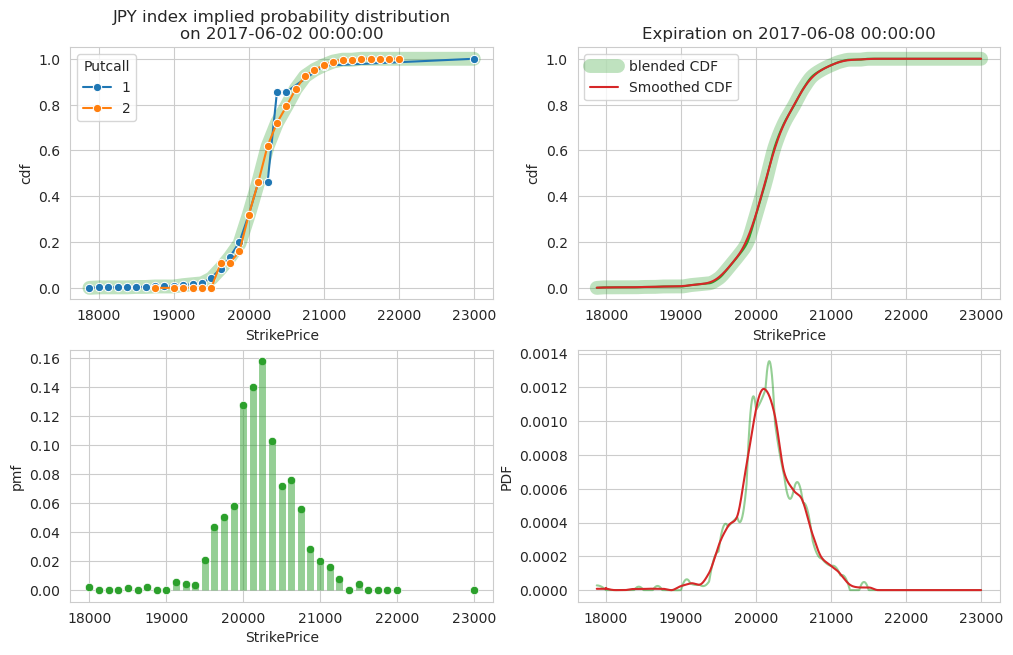

In [26]:
def center_dydx(x, y):
    return (np.roll(y, shift = -1)[:-1] - np.roll(y, shift = 1)[1:])/np.diff(x)
# example 6 has a smooth curve (('2017-11-09 00:00:00'), ('2017-11-09 00:00:00'))
# example 654  bimodal distribution: (('2017-03-02 00:00:00'), ('2017-03-09 00:00:00'))

i = 11
example = chain_list.index[i]
print(example[:-1])
df = options.loc[example[:-1]]
imp_df = implied.loc[example[:-1]]
interp_df = interp_implied.loc[example[:-1]]
x_data = imp_df.index.get_level_values(-1)
y_data = imp_df.cdf.values
interp = PchipInterpolator(x= x_data, y = y_data)
x_samp = np.linspace(x_data.min(), x_data.max(), num = 1000)
y_samp = interp(x_samp)
# dydx = (np.roll(y_samp, shift = -1)[:-1] - np.roll(y_samp, shift = 1)[1:])/np.diff(x_samp)
dydx = center_dydx(x_samp, y_samp)


y_sm = savgol_filter(y_data,  3, polyorder=1)
interp_sm = PchipInterpolator(x_data, y_sm)
y_sm_samp = interp_sm(x_samp)
y_sm_samp = savgol_filter(y_samp, int(50), 1)
dysm_dx =  center_dydx(x_samp, y_sm_samp)

fig, ax = plt.subplots(2,2,figsize = (8*1.5,6*1.2) )
ax[0, 0].set_title(f'JPY index implied probability distribution\non {example[0]}')
ax[0, 1].set_title(f'Expiration on {example[1]}')

# AXES[0,0] CDF blending
sns.lineplot(imp_df, x='StrikePrice', y='cdf', ax=ax[0, 0], color = 'tab:green', linewidth = 10,alpha =0.3)
sns.lineplot(df, x = 'StrikePrice', y = 'cdf_iso_weighted', marker = 'o', ax=ax[0, 0], **plot_args)

# AXES[1, 0]
sns.scatterplot(imp_df, x = 'StrikePrice', y='pmf', ax = ax[1, 0], alpha = 1, color='tab:green')
for i, row in imp_df.iterrows():
    ax[1, 0].vlines(row['K'], 0, row['pmf'], alpha =0.5, linewidth = 5, color = 'tab:green')

# AXES[0,1]
sns.lineplot(interp_df, x='StrikePrice', y='cdf', ax=ax[0, 1], color = 'tab:green', label='blended CDF', linewidth = 10,alpha =0.3)
ax[0, 1].plot(x_samp, y_samp, color='tab:green')
ax[0, 1].plot(x_samp, y_sm_samp, color = 'tab:red', label='Smoothed CDF')
ax[0, 1].legend()

# AXES[1, 1]
ax[1,1].plot(x_samp[1:], dydx, color='tab:green', alpha = 0.5)
ax[1,1].plot(x_samp[1:], dysm_dx, color='tab:red')

ax[1,1].set_ylabel('PDF')

# Annotations 
# for axe in ax:
#     for a in axe:
#         for percentile in [0.92, 1, 1.08]:
#             # print(df['UnderlyingClose'].iloc[0]*percentile)
#             a.axvline(df['UnderlyingClose'].iloc[0]*percentile, color = 'k', linestyle = ':')

<font size = 5>

* The implied CDF between puts and calls are volume weighted averaged (VWA).  Volume weighting reduces the impacts of unreliable data. 
* A monotonic spline is used to interpolate the VWA CDF, and is smoothed by a 1st order Savitzky Golay filter.  


# Comments on the PMF and PDF
* Just by scrolling through some examples, it seems like I've computed all sorts of funky distributions.  
* To resummarize this approach, I blended the CDFs weighted by the volume of trades at a particular strike

In [23]:
# options.groupby(['Date', 'Expiry'], group_keys=False).apply()

## CDF calculation Notes
General comments on the data cleaning:
* Isotonic regression with the premiums vs strikes seems to be a good diea.  
* Isotonoic regressor should be given that ymin and y max are 0 and 1 for the cdf, it seems like that what the regressor converges to usually.
* Maybe I should use weighted isotonic regression, and weight by the log of the volume.  
* interesting paper link https://dl.acm.org/doi/10.1145/1102351.1102430 suggest platt scaling might be something to look into

Finance/scientific remarks:
* It's interesting that the tail behaviors of the put and call options have different tails.  In some sense, the implied probability distribution from puts and calls reveals the sentiment of bullish investors v.s. the bearish investors.
* But these tails derive from quite noisy data.  Perhaps blending the two distributions would reveal some facts about overall volatility in the market.  